In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import glob
import sys, copy
import numpy as np
import pyccl as ccl
sys.path.append('../modules/')
import ModelClusterObservables
import halo._halo_abundance
import matplotlib.pyplot as plt
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# Define Count and lensing mass models

In [2]:
import configparser
default_config_capish = configparser.ConfigParser()
default_config_capish.read('../config/capish.ini')
default_config_capish['summary_statistics']['richness_edges'] = '20, 25, 30, 35, 40, 50, 80, 100'
default_config_capish['summary_statistics']['redshift_edges'] = '0.2, 0.5'

In [3]:
ClusterAbundanceObject = ModelClusterObservables.UniversePrediction( default_config=default_config_capish )

In [4]:
params_default = ClusterAbundanceObject.params_default 
cosmo_fid = params_default['CCL_cosmology']
params_new = params_default
compute_new= {'compute_dNdzdlogMdOmega':False,'compute_richness_mass_relation':False, 
               'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':True,
             'compute_dNdzdlogMdOmega_log_slope': False}
adds_new={'add_purity':False, 'add_completeness':False}

In [5]:
skyarea = ClusterAbundanceObject.HaloAbundanceObject.sky_area
fsky = skyarea/(4*np.pi)

In [6]:
Nfid = ClusterAbundanceObject.model_count(params_new, compute_new, adds_new)

In [7]:
Nbfid = ClusterAbundanceObject.model_bias(params_new, compute_new, adds_new)
bfid = Nbfid/Nfid

In [8]:
SSC = halo._halo_abundance.HaloAbundance()
cosmo_fid = ccl.Cosmology( Omega_c = float( default_config_capish['halo_catalogue']['Omega_c_fiducial'] ), 
                               Omega_b = float( default_config_capish['halo_catalogue']['Omega_b_fiducial'] ), 
                               h = float( default_config_capish['halo_catalogue']['h_fiducial'] ), 
                               sigma8 = float( default_config_capish['halo_catalogue']['sigma_8_fiducial'] ), 
                               n_s=float( default_config_capish['halo_catalogue']['n_s_fiducial'] ) )
Sij = SSC.compute_theoretical_Sij([[0.2, 0.5]], cosmo_fid, fsky, S_ij_type = 'full_sky_rescaled_approx', )

In [9]:
res_default_capish = np.mean(np.array(load('default_capish.pkl'))[:,0], axis=0)
res_with_photoz = np.mean(np.array(load('with_photoz.pkl'))[:,0], axis=0)
res_gauss_only_MoR = np.mean(np.array(load('Gauss-only_MoR.pkl'))[:,0], axis=0)
res_incomplete = np.mean(np.array(load('incomplete.pkl'))[:,0], axis=0)
res_not_pure = np.mean(np.array(load('not_pure.pkl'))[:,0], axis=0)
res_not_pure_and_incomplete = np.mean(np.array(load('not_pure_and_incomplete.pkl'))[:,0], axis=0)

In [10]:
std_default_capish = np.std(np.array(load('default_capish.pkl'))[:,0], axis=0, ddof=1)
var_th = Nfid + Nfid **2 * bfid **2 * Sij[0]

Text(0.5, 0, 'richness')

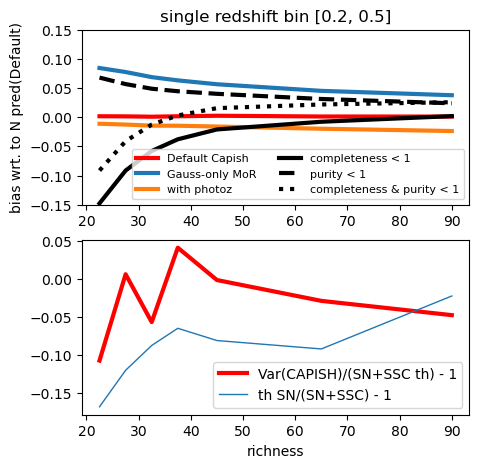

In [11]:
plt.figure(figsize=(5,5))
plt.subplot(211)
plt.title('single redshift bin [0.2, 0.5]')
plt.plot(ClusterAbundanceObject.richness_centers, res_default_capish/Nfid - 1, '-r', lw=3, label = 'Default Capish')
plt.plot(ClusterAbundanceObject.richness_centers, res_gauss_only_MoR/Nfid - 1, lw=3, label = 'Gauss-only MoR')
plt.plot(ClusterAbundanceObject.richness_centers, res_with_photoz/Nfid - 1, lw=3, label = 'with photoz')
plt.plot(ClusterAbundanceObject.richness_centers, res_incomplete/Nfid - 1, '-k', lw=3, label = 'completeness < 1')
plt.plot(ClusterAbundanceObject.richness_centers, res_not_pure/Nfid - 1, '--k', lw=3, label = 'purity < 1')
plt.plot(ClusterAbundanceObject.richness_centers, res_not_pure_and_incomplete/Nfid - 1, ':k', lw=3, label = 'completeness & purity < 1')
plt.legend(fontsize=8, ncols=2)
plt.ylabel(r'bias wrt. to N pred(Default)')
plt.ylim(-0.15, 0.15)
plt.subplot(212)
plt.plot(ClusterAbundanceObject.richness_centers, std_default_capish/np.sqrt(var_th) - 1, '-r', lw=3, label = 'Var(CAPISH)/(SN+SSC th) - 1')
plt.plot(ClusterAbundanceObject.richness_centers, np.sqrt(Nfid)/np.sqrt(var_th) - 1, '-', lw=1, label = 'th SN/(SN+SSC) - 1')
plt.legend()
plt.xlabel('richness')
#plt.plot(ClusterAbundanceObject.richness_centers, std_default_capish/np.sqrt(Nfid) - 1, ':', lw=3, label = 'Default Capish')

In [12]:
#res_no_completeness = load('/pbs/throng/lsst/users/cpayerne/capish/validation_standard/sims_no_completeness.pkl')
#res_no_purity = load('/pbs/throng/lsst/users/cpayerne/capish/validation_standard/sims_no_purity.pkl')
#res_incomplete_impure = load('/pbs/throng/lsst/users/cpayerne/capish/validation_standard/sims_incomplete_impure.pkl')
#res_no_completeness_no_purity = load('/pbs/throng/lsst/users/cpayerne/capish/validation_standard/sims_no_completeness_no_purity.pkl')

In [13]:
#N_no_completeness_no_purity = np.average(np.array(res_no_completeness_no_purity)[:,0], axis=0)
#N_incomplete_impure = np.average(np.array(res_incomplete_impure)[:,0], axis=0)
#N_no_purity = np.average(np.array(res_no_purity)[:,0], axis=0)
#N_no_completeness = np.average(np.array(res_no_completeness)[:,0], axis=0)